In [1]:
import sys
sys.path.append('../')


In [2]:
from DPF import ShardsDatasetConfig, DatasetReader

config = ShardsDatasetConfig.from_path_and_columns(
    'example_dataset',
    image_name_col='image_name',
    text_col="caption"
)

reader = DatasetReader()
processor = reader.read_from_config(config)


/home/user/conda/envs/dpf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 3/3 [00:00<00:00, 318.39it/s]


## Check dataset samples and summary info

In [3]:
processor.print_summary()


Dataset format: shards
Path: example_dataset
Modalities: ['image', 'text']
Columns: 3
Total samples: 500


In [4]:
processor.df


,image_path,text,split_name
0,example_dataset/0.tar/0.jpg,шотландцы в национальной одежде с флагом. - ba...,0
1,example_dataset/0.tar/1.jpg,королевская золотая корона с драгоценностями н...,0
2,example_dataset/0.tar/2.jpg,Пасха,0
3,example_dataset/0.tar/3.jpg,округа нью-джерси карта печати - elizabeth sto...,0
4,example_dataset/0.tar/4.jpg,"английская золотая корона с драгоценностями, и...",0
...,...,...,...
495,example_dataset/2.tar/495.jpg,bokeh Background,2
496,example_dataset/2.tar/496.jpg,"Healthcare, Medicine,",2
497,example_dataset/2.tar/497.jpg,A set of business teams icons that include edi...,2
498,example_dataset/2.tar/498.jpg,Vector floral pattern icon collection,2


# Filters

## Image info filter

In [7]:
from DPF.filters.images.info_filter import ImageInfoFilter

datafilter = ImageInfoFilter(workers=16)
processor.apply_data_filter(datafilter)


100%|██████████| 500/500 [00:00<00:00, 588.61it/s]


In [8]:
processor.df # new columns is_correct, width, height, channels, error are added


,image_path,text,split_name,is_correct,width,height,channels,error
0,example_dataset/0.tar/0.jpg,шотландцы в национальной одежде с флагом. - ba...,0,True,612,612,3,None
1,example_dataset/0.tar/1.jpg,королевская золотая корона с драгоценностями н...,0,True,612,306,3,None
2,example_dataset/0.tar/2.jpg,Пасха,0,True,640,360,3,None
3,example_dataset/0.tar/3.jpg,округа нью-джерси карта печати - elizabeth sto...,0,True,464,612,3,None
4,example_dataset/0.tar/4.jpg,"английская золотая корона с драгоценностями, и...",0,True,612,612,3,None
...,...,...,...,...,...,...,...,...
495,example_dataset/2.tar/495.jpg,bokeh Background,2,True,612,344,3,None
496,example_dataset/2.tar/496.jpg,"Healthcare, Medicine,",2,True,612,612,3,None
497,example_dataset/2.tar/497.jpg,A set of business teams icons that include edi...,2,True,612,612,3,None
498,example_dataset/2.tar/498.jpg,Vector floral pattern icon collection,2,True,612,612,3,None


## PHash filter

In [5]:
from DPF.filters.images.hash_filters import PHashFilter

datafilter = PHashFilter(sim_hash_size=8, workers=16)
processor.apply_data_filter(datafilter)


100%|██████████| 500/500 [00:01<00:00, 345.42it/s]


In [6]:
processor.df['image_phash_8'] # Perceptual hash of images


0      e1f6e7c0e07f0e3d381f8fc07e09c7f0103fe07038ec7918
1      fc3100ffcd0b6301c8ef9f1c0399d8030ebfe38e047db03f
2      effe38e3be07747080a1d9d8fe2fe80081f8ff8c2701f018
3      ec4007e06e0113b7f8f007e603f63f1381d81f8fff027e33
4      e3f1c6ec703ffc01b81b9fc0216e0703efc2fc01b1fa81f0
                             ...                       
495    e431028fcd3581f1e6f073071df63df139c303b3d0f23417
496    fb8efe188cc61869c6187c6618f9c019ec4618fc771c8ff8
497    fc70381c70381c71f81c71f81c70385fbe07e38fc7e38fc0
498    e80f7f080d3c0fc13e0c4770f03ec5f38281f7e1bbe0b1c7
499    fbf03803f03ce001fc1b8fc103fe073c7e38fc01b8e381df
Name: image_phash_8, Length: 500, dtype: object

## ImprovedAestheticFilter (from LAION)

In [11]:
from DPF.filters.images.aesthetic_improved_filter import ImprovedAestheticFilter

datafilter = ImprovedAestheticFilter(
    weights_folder='../weights',  # path to weights folder, will be downloaded to this folder
    device='cuda:0',
    workers=16
)
print(datafilter.result_columns)
processor.apply_data_filter(datafilter)


['improved_aesthetic_score_ViT-L/14']


10it [00:05,  1.95it/s]                      


In [12]:
processor.df['improved_aesthetic_score_ViT-L/14']


0      5.601146
1      4.966230
2      5.068741
3      4.848436
4      5.539761
         ...   
495    5.285481
496    4.501980
497    3.883074
498    5.069400
499    4.538239
Name: improved_aesthetic_score_ViT-L/14, Length: 500, dtype: float64

## CLIPLabelsFilter 

In [13]:
from DPF.filters.images.cliplabels_filter import CLIPLabelsFilter

datafilter = CLIPLabelsFilter(
    clip_model='ViT-L/14',
    labels=['photo of a car', 'photo of a man', 'photo of a dog'],
    weights_folder='../weights', # path to weights folder, will be downloaded to this folder
    device='cuda:0',
    workers=16
)
print(datafilter.result_columns)
processor.apply_data_filter(datafilter)


['ViT-L/14 clip score "photo of a car"', 'ViT-L/14 clip score "photo of a man"', 'ViT-L/14 clip score "photo of a dog"']


10it [00:03,  2.52it/s]                      


In [14]:
colname = 'ViT-L/14 clip score "photo of a dog"'
processor.df[colname]


0      0.049438
1      0.090820
2      0.124451
3      0.110779
4      0.104065
         ...   
495    0.134888
496    0.046631
497    0.003983
498    0.075867
499    0.063782
Name: ViT-L/14 clip score "photo of a dog", Length: 500, dtype: float64

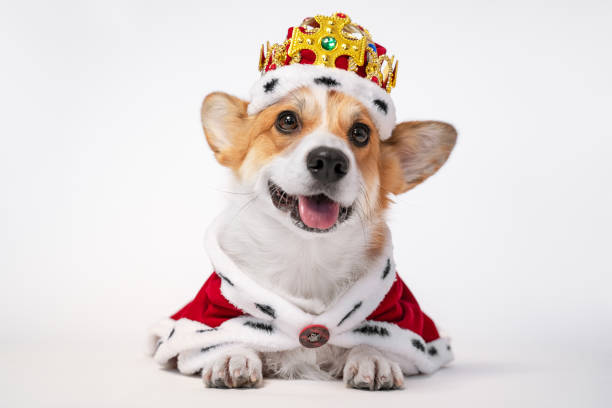

In [15]:
from PIL import Image
import io

m2d, metadata = processor.get_random_sample(processor.df[colname]>0.22)
Image.open(io.BytesIO(m2d['image']))


## WatermarksFilter

In [16]:
from DPF.filters.images.watermarks_filter import WatermarksFilter

datafilter = WatermarksFilter(
    watermarks_model='resnext101_32x8d-large',
    weights_folder='../weights', # path to weights folder, will be downloaded to this folder
    device='cuda:0',
    workers=16
)
print(datafilter.result_columns)
processor.apply_data_filter(datafilter)


/home/jovyan/.mlspace/envs/dpf_llava/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jovyan/.mlspace/envs/dpf_llava/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/jovyan/.mlspace/envs/dpf_llava/lib/python3.11/site-packages/huggingface_hub/file_download.py:669: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


['watermark_resnext101_32x8d-large']


10it [00:04,  2.42it/s]                      


In [17]:
processor.df['watermark_resnext101_32x8d-large']


0      1
1      0
2      0
3      0
4      0
      ..
495    1
496    1
497    1
498    1
499    1
Name: watermark_resnext101_32x8d-large, Length: 500, dtype: int64

## Text detection

In [3]:
from DPF.filters.images.text_detection_filter import CRAFTFilter

datafilter = CRAFTFilter(
    '../weights',
    device="cuda:0",
    workers=16
)
print(datafilter.result_columns)
processor.apply_data_filter(datafilter)


2024-05-22 13:34:51.322120: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 13:34:52.049444: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/user/conda/envs/dpf/lib/python3.11/site-packages/huggingface_hub/file_download.py:671: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(
/home/user/conda/envs/dpf/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/conda/envs/dpf/lib/python3.11/site-packages/torchvision/models/_utils.py:22

['text_boxes', 'num_text_boxes', 'text_area']


  1%|▏         | 7/500 [00:01<00:53,  9.14it/s]/home/user/conda/envs/dpf/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 500/500 [00:14<00:00, 35.06it/s]


In [4]:
processor.df[datafilter.result_columns]


,text_boxes,num_text_boxes,text_area
0,"[[[161, 310], [170, 321]], [[188, 309], [198, ...",9,0.013609
1,[],0,0.000000
2,[],0,0.000000
3,"[[[226, 93], [252, 101]], [[276, 104], [304, 1...",20,0.018773
4,[],0,0.000000
...,...,...,...
495,[],0,0.000000
496,"[[[461, 17], [518, 58]], [[42, 24], [162, 50]]...",13,0.147358
497,"[[[511, 33], [587, 57]], [[510, 62], [589, 90]...",3,0.012431
498,[],0,0.000000


# Captioning

## LLaVaCaptioningFilter

In [9]:
from DPF.filters.images.llava_captioning_filter import LLaVaCaptioningFilter

datafilter = LLaVaCaptioningFilter(
    workers=16, 
    prompt='pixart', 
    batch_size=8, 
    device='cuda:0'
)

processor.apply_data_filter(datafilter)


Describe this image and its style in a very detailed manner


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14-336 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.8.self_attn.v_proj.bias', 'text_model.encoder.layers.8.layer_norm1.bias', 'text_model.encoder.layers.7.layer_norm1.weight', 'text_model.encoder.layers.4.mlp.fc2.bias', 'text_model.encoder.layers.2.layer_norm2.bias', 'text_model.encoder.layers.3.self_attn.q_proj.weight', 'text_model.encoder.layers.4.self_attn.out_proj.weight', 'text_model.encoder.layers.2.mlp.fc1.bias', 'text_model.encoder.layers.8.self_attn.out_proj.weight', 'text_model.encoder.layers.1.self_attn.v_proj.weight', 'text_model.encoder.layers.2.self_attn.q_proj.weight', 'text_model.encoder.layers.0.mlp.fc2.weight', 'text_model.encoder.layers.0.layer_norm1.bias', 'text_model.encoder.layers.4.self_attn.q_proj.bias', 'text_model.encoder.layers.6.self_attn.q_proj.bias', 'visual_projection.weight', 'text_model.encoder.layers.4.mlp.fc1.weight', 'text_model.encoder.layers.5.layer_n

100%|██████████| 63/63 [09:56<00:00,  9.48s/it]


In [ ]:
processor.df['caption liuhaotian/llava-v1.5-13b prompt pixart']


## LLaVa34bCaptioningFilter

In [1]:
import sys
sys.path.append('../')
from DPF import ShardsDatasetConfig, DatasetReader

config = ShardsDatasetConfig.from_path_and_columns(
    'example_dataset',
    image_name_col='image_name',
    text_col="text"
)

reader = DatasetReader()
processor = reader.read_from_config(config)

/home/jovyan/.mlspace/envs/env3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


In [2]:
from DPF.filters.images.llava34b_captioning_filter import Llava34b_Filter

datafilter = Llava34b_Filter(
    workers=1, 
    batch_size=4, 
    device='cuda:0',
    crop_size_x = 336,
    crop_size_y = 336
)

processor.apply_data_filter(datafilter)

[2024-05-12 12:42:04,347] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour
100%|██████████| 250/250 [1:30:04<00:00, 21.62s/it]


In [6]:
processor.df['llava-v1.6-34b']

0      The image depicts an older couple in a kitchen...
1      The image shows a close-up of two bowls of gre...
2      The image shows a golden retriever dog swimmin...
3      The image depicts a tranquil scene at what app...
4      The image depicts a serene landscape featuring...
                             ...                        
995    The image depicts an aerial view of a densely ...
996    The image depicts an impressionist painting of...
997    The image depicts a modern and stylish interio...
998    The image depicts a stylized, fantasy-themed l...
999    The image shows a pair of dark blue trousers w...
Name: fix all caption liuhaotian/llava-v1.6-34b prompt short, Length: 1000, dtype: object

## BLIP captioning

In [4]:
from DPF.filters.images.blip_captioning_filter import BLIPCaptioningFilter

datafilter = BLIPCaptioningFilter(
    workers=16, 
    batch_size=32, 
    device='cuda:0'
)

processor.apply_data_filter(datafilter)


[2024-05-22 13:41:44,754] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/user/conda/envs/dpf/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
18it [00:50,  2.79s/it]                        


In [5]:
processor.df['blip_caption']


0         a man and a woman dressed in scottish clothing
1               a british flag with a crown on top of it
2         a couple of people that are painting some eggs
3                       a map of the state of new jersey
4      a purple and gold crown sitting on top of a wh...
                             ...                        
495             a blurry image of rain drops on a window
496              a large set of medical and health icons
497                  a large set of line icons of people
498    a bunch of different colored circles on a whit...
499                  a set of various ribbons and badges
Name: blip_caption, Length: 500, dtype: object

In [7]:
processor.df[['text', 'blip_caption']]


,text,blip_caption
0,шотландцы в национальной одежде с флагом. - ba...,a man and a woman dressed in scottish clothing
1,королевская золотая корона с драгоценностями н...,a british flag with a crown on top of it
2,Пасха,a couple of people that are painting some eggs
3,округа нью-джерси карта печати - elizabeth sto...,a map of the state of new jersey
4,"английская золотая корона с драгоценностями, и...",a purple and gold crown sitting on top of a wh...
...,...,...
495,bokeh Background,a blurry image of rain drops on a window
496,"Healthcare, Medicine,",a large set of medical and health icons
497,A set of business teams icons that include edi...,a large set of line icons of people
498,Vector floral pattern icon collection,a bunch of different colored circles on a whit...
